In [1]:
# train_pos_seq2seq.py
# Full, self-contained training script: Encoder–Decoder with a manual LSTM for POS tagging.

import os
import random
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
# -----------------------------
# 0) Repro + Device
# -----------------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# -----------------------------
# 1) Data: Brown (Universal tags)
# -----------------------------
import nltk
from nltk.corpus import brown

def prepare_brown(max_len=40, min_freq=1, use_universal=True):
    nltk.download("brown", quiet=True)
    if use_universal:
        nltk.download("universal_tagset", quiet=True)
        tagged_sents = brown.tagged_sents(tagset="universal")
    else:
        tagged_sents = brown.tagged_sents()

    # sentences: list[list[str]], tags: list[list[str]]
    sentences = [[w for w, t in sent] for sent in tagged_sents]
    tags = [[t for w, t in sent] for sent in tagged_sents]

    # word vocab
    word_freq = Counter(w.lower() for sent in sentences for w in sent)
    word2idx = {"<PAD>": 0, "<UNK>": 1}
    for w, c in word_freq.items():
        if c >= min_freq:
            word2idx[w] = len(word2idx)
    idx2word = {i: w for w, i in word2idx.items()}

    # tag vocab (include <PAD>, <SOS>)
    tag_set = sorted({t for ts in tags for t in ts})
    tag2idx = {"<PAD>": 0, "<SOS>": 1}
    for t in tag_set:
        tag2idx[t] = len(tag2idx)
    idx2tag = {i: t for t, i in tag2idx.items()}

    def encode_sentence(tokens):
        return [word2idx.get(w.lower(), word2idx["<UNK>"]) for w in tokens]

    def encode_tags(ts):
        return [tag2idx[t] for t in ts]

    # encode
    X = [encode_sentence(s) for s in sentences]
    Y = [encode_tags(ts) for ts in tags]

    # split (80/10/10)
    N = len(X)
    idxs = list(range(N))
    random.shuffle(idxs)
    n_train = int(0.8 * N)
    n_val = int(0.1 * N)
    train_idx = idxs[:n_train]
    val_idx = idxs[n_train:n_train + n_val]
    test_idx = idxs[n_train + n_val:]

    def subset(lst, ids):
        return [lst[i] for i in ids]

    X_tr, Y_tr = subset(X, train_idx), subset(Y, train_idx)
    X_va, Y_va = subset(X, val_idx), subset(Y, val_idx)
    X_te, Y_te = subset(X, test_idx), subset(Y, test_idx)

    return (X_tr, Y_tr, X_va, Y_va, X_te, Y_te,
            word2idx, idx2word, tag2idx, idx2tag, max_len)

def pad_to_len(seq, L, pad):
    if len(seq) >= L:
        return seq[:L]
    return seq + [pad] * (L - len(seq))

class BrownPOSDataset(Dataset):
    """
    For MT-style training:
    - encoder input: X  (word ids, padded)
    - decoder input: Y_in  = <SOS> + gold tags (shifted right)
    - decoder target: Y_out = gold tags + <PAD> (aligned with Y_in)
    """
    def __init__(self, X, Y, word2idx, tag2idx, max_len=40):
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

        PADw = word2idx["<PAD>"]
        PADt = tag2idx["<PAD>"]
        SOS = tag2idx["<SOS>"]

        self.X = [pad_to_len(x, max_len, PADw) for x in X]
        self.Y_in = [pad_to_len([SOS] + y, max_len, PADt) for y in Y]
        self.Y_out = [pad_to_len(y + [PADt], max_len, PADt) for y in Y]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return (torch.tensor(self.X[i], dtype=torch.long),
                torch.tensor(self.Y_in[i], dtype=torch.long),
                torch.tensor(self.Y_out[i], dtype=torch.long))

In [4]:
# -----------------------------
# 2) Manual LSTM cell
# -----------------------------
class MyLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.W = nn.Linear(input_dim + hidden_dim, 4 * hidden_dim)

    def forward(self, x_t, h_prev, c_prev):
        # x_t: [B, D], h_prev/c_prev: [B, H]
        z = torch.cat([x_t, h_prev], dim=1)
        i, f, g, o = torch.chunk(self.W(z), 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        c_t = f * c_prev + i * g
        h_t = o * torch.tanh(c_t)
        return h_t, c_t

# -----------------------------
# 3) Encoder
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.cell = MyLSTMCell(emb_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [B, T]
        B, T = src.size()
        h = src.new_zeros((B, self.hidden_dim), dtype=torch.float32).to(src.device)
        c = src.new_zeros((B, self.hidden_dim), dtype=torch.float32).to(src.device)

        emb = self.embedding(src)  # [B, T, E]
        for t in range(T):
            x_t = self.dropout(emb[:, t, :])
            h, c = self.cell(x_t, h, c)
        # return final states (no attention; MT-style context = final states)
        return h, c

# -----------------------------
# 4) Decoder (autoregressive, MT-style)
# -----------------------------
class Decoder(nn.Module):
    def __init__(self, num_tags, emb_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(num_tags, emb_dim, padding_idx=0)
        self.cell = MyLSTMCell(emb_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_tags)
        self.dropout = nn.Dropout(dropout)

    def forward(self, enc_h, enc_c, trg_in, teacher_forcing_ratio=0.5):
        """
        enc_h, enc_c: [B, H] encoder final states
        trg_in: [B, T] shifted gold (starts with <SOS>)
        """
        B, T = trg_in.size()
        h, c = enc_h, enc_c
        logits_list = []

        input_token = trg_in[:, 0]  # first input should be <SOS>

        for t in range(T):
            emb = self.dropout(self.embedding(input_token))  # [B, E]
            h, c = self.cell(emb, h, c)
            logits = self.fc_out(h)  # [B, num_tags]
            logits_list.append(logits.unsqueeze(1))

            if t + 1 < T:
                use_teacher = random.random() < teacher_forcing_ratio
                next_gold = trg_in[:, t + 1]
                next_pred = logits.argmax(dim=1)
                input_token = next_gold if use_teacher else next_pred

        return torch.cat(logits_list, dim=1)  # [B, T, num_tags]

# -----------------------------
# 5) Seq2Seq wrapper
# -----------------------------
class Seq2SeqTagger(nn.Module):
    def __init__(self, vocab_size, tag_size, emb_dim=128, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim, dropout)
        self.decoder = Decoder(tag_size, emb_dim, hidden_dim, dropout)
        self.tag_size = tag_size

    def forward(self, src, trg_in, teacher_forcing_ratio=0.5):
        enc_h, enc_c = self.encoder(src)
        return self.decoder(enc_h, enc_c, trg_in, teacher_forcing_ratio)

In [5]:
# -----------------------------
# 6) Training / Evaluation utils
# -----------------------------
def token_accuracy(logits, targets, pad_idx=0):
    """
    logits: [B, T, C], targets: [B, T]
    ignores positions where targets == pad_idx
    """
    with torch.no_grad():
        preds = logits.argmax(dim=-1)  # [B, T]
        mask = (targets != pad_idx)
        correct = ((preds == targets) & mask).sum().item()
        total = mask.sum().item()
        return correct / max(1, total)

def evaluate(model, loader, criterion, pad_idx):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0
    with torch.no_grad():
        for x, y_in, y_out in loader:
            x, y_in, y_out = x.to(device), y_in.to(device), y_out.to(device)
            logits = model(x, y_in, teacher_forcing_ratio=0.0)  # no TF at eval
            loss = criterion(logits.view(-1, model.tag_size), y_out.view(-1))
            acc = token_accuracy(logits, y_out, pad_idx)
            total_loss += loss.item()
            total_acc += acc
            n_batches += 1
    return total_loss / n_batches, total_acc / n_batches

def greedy_decode(model, sentence_tokens, word2idx, idx2tag, max_len, max_steps=None):
    """
    sentence_tokens: list[str] (already tokenized)
    Returns list[str] POS tags predicted.
    """
    model.eval()
    if max_steps is None:
        max_steps = max_len

    PADw = word2idx["<PAD>"]
    PADt = 0
    SOS = 1

    x = [word2idx.get(w.lower(), word2idx["<UNK>"]) for w in sentence_tokens]
    x = pad_to_len(x, max_len, PADw)
    x = torch.tensor(x, dtype=torch.long, device=device).unsqueeze(0)  # [1, T]

    with torch.no_grad():
        enc_h, enc_c = model.encoder(x)
        # start token for decoder
        inp = torch.tensor([SOS], dtype=torch.long, device=device)  # [1]
        h, c = enc_h, enc_c
        tags = []
        for t in range(max_steps):
            emb = model.decoder.embedding(inp)
            h, c = model.decoder.cell(emb, h, c)
            logit = model.decoder.fc_out(h)        # [1, C]
            pred = logit.argmax(dim=1)             # [1]
            tags.append(pred.item())
            inp = pred  # next input is previous prediction

        # map indices to tags, trim to original sent length
        tags = tags[:len(sentence_tokens)]
        tags_str = [idx2tag.get(i, "UNK") for i in tags]
        return tags_str

def evaluate_model(model, test_loader, tag2idx, idx2tag, device="cuda"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for words, y_in, y_out in test_loader:  # unpack all 3
            words, y_in, y_out = words.to(device), y_in.to(device), y_out.to(device)

            # Forward pass
            outputs = model(words, y_in)  # [batch, seq_len, num_tags]
            predictions = torch.argmax(outputs, dim=-1)

            # Collect predictions and labels (ignoring <PAD>)
            for i in range(words.size(0)):
                for j in range(words.size(1)):
                    if y_out[i, j].item() != tag2idx["<PAD>"]:
                        y_true.append(y_out[i, j].item())
                        y_pred.append(predictions[i, j].item())

    return y_true, y_pred

Device: cuda
Vocab size: 49817, Tags: 14
Train/Val/Test sizes: 45872/5734/5734
Epoch 01 | Train Loss 1.8927 | Val Loss 2.0921 | Val Acc 26.17%
Epoch 02 | Train Loss 1.6628 | Val Loss 1.8439 | Val Acc 33.38%
Epoch 03 | Train Loss 1.4721 | Val Loss 1.6853 | Val Acc 39.24%
Epoch 04 | Train Loss 1.3362 | Val Loss 1.5487 | Val Acc 43.77%
Epoch 05 | Train Loss 1.2264 | Val Loss 1.4113 | Val Acc 48.42%
Epoch 06 | Train Loss 1.1173 | Val Loss 1.2843 | Val Acc 53.39%
Epoch 07 | Train Loss 1.0143 | Val Loss 1.1713 | Val Acc 57.63%
Epoch 08 | Train Loss 0.9509 | Val Loss 1.1023 | Val Acc 60.24%
Epoch 09 | Train Loss 0.9312 | Val Loss 1.0975 | Val Acc 60.80%
Epoch 10 | Train Loss 0.9121 | Val Loss 1.1113 | Val Acc 60.14%
Epoch 11 | Train Loss 0.8620 | Val Loss 1.0519 | Val Acc 62.23%
Epoch 12 | Train Loss 0.8270 | Val Loss 0.9904 | Val Acc 64.62%
Epoch 13 | Train Loss 0.7913 | Val Loss 0.9697 | Val Acc 65.37%
Epoch 14 | Train Loss 0.7684 | Val Loss 0.9532 | Val Acc 66.01%
Epoch 15 | Train Loss 0.7

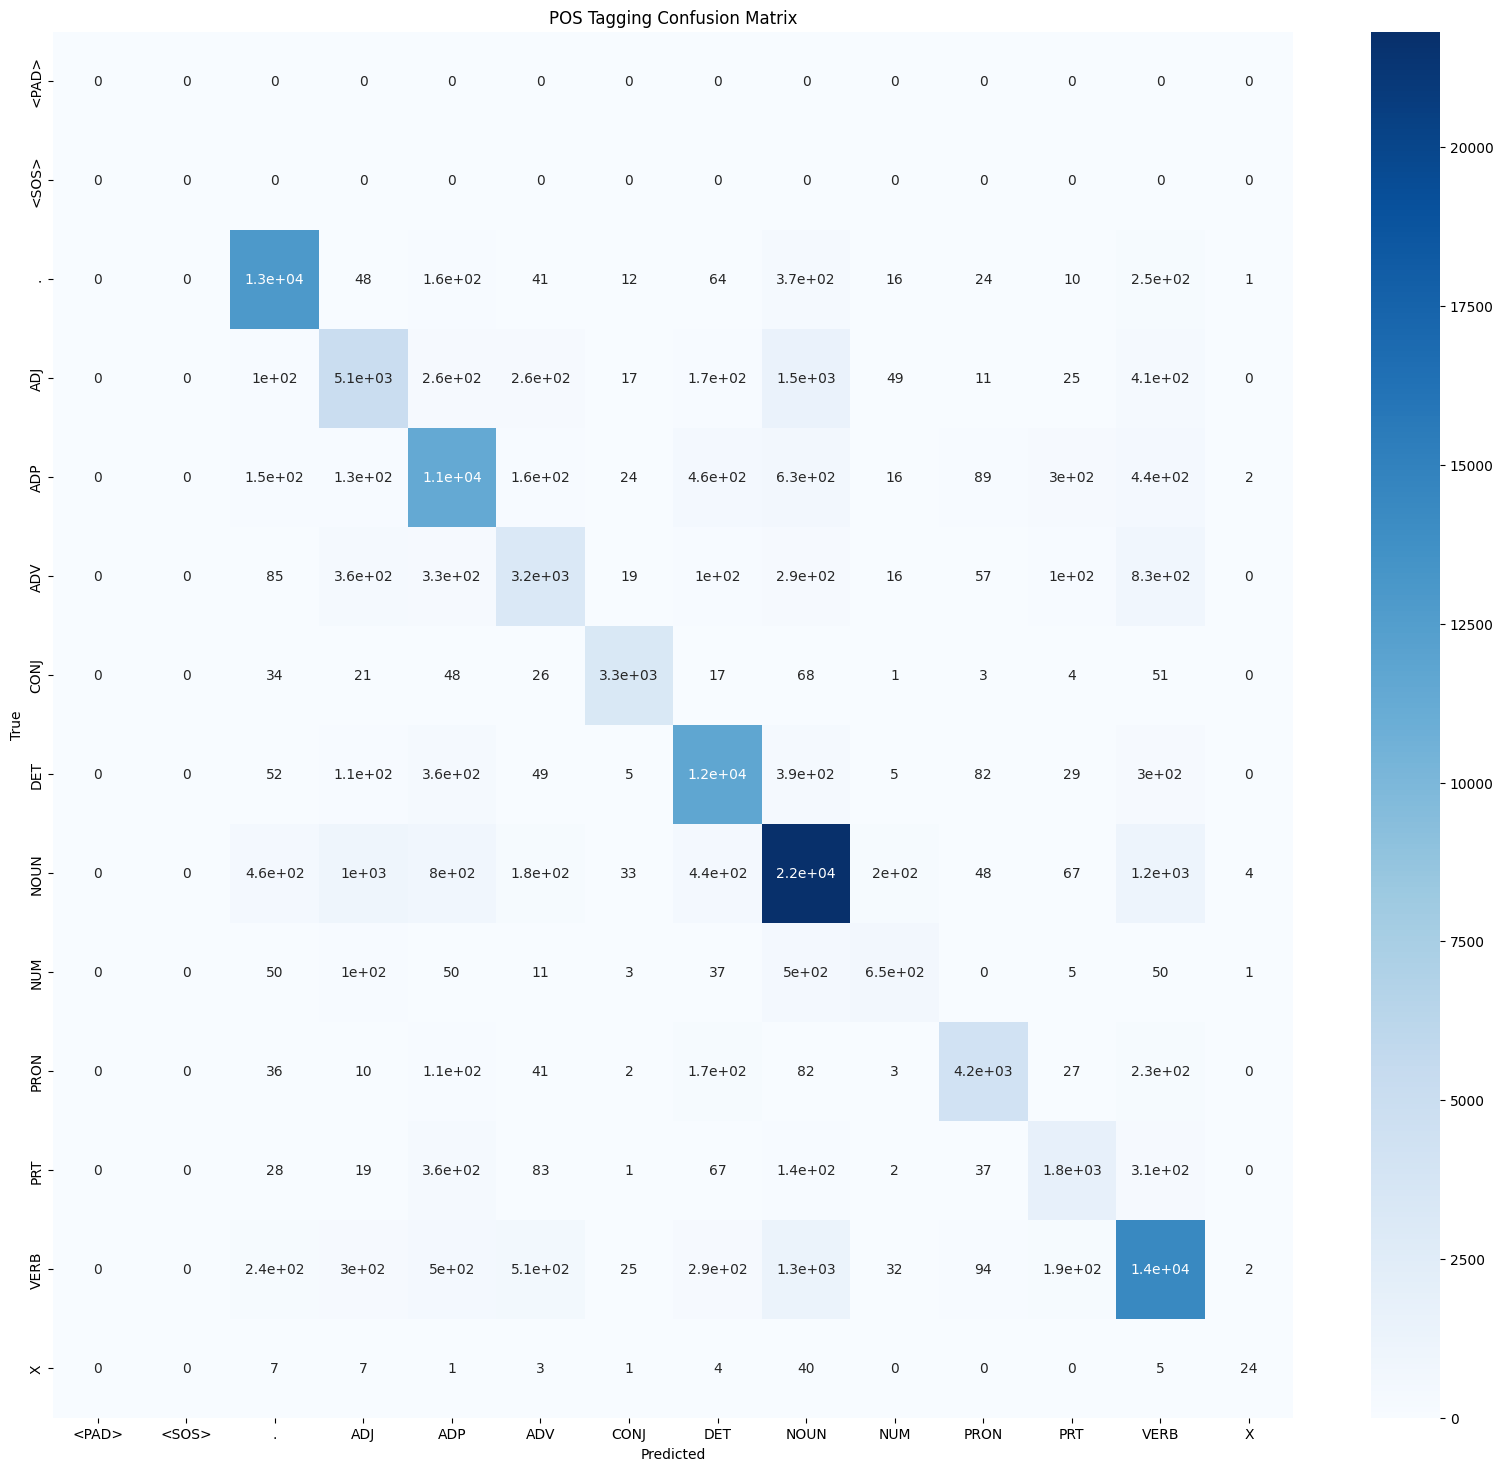

In [6]:
# -----------------------------
# 7) Main
# -----------------------------
def main():
    # Hyperparams
    MAX_LEN = 40
    MIN_FREQ = 1
    BATCH_SIZE = 64
    EMB_DIM = 128
    HID_DIM = 256
    DROPOUT = 0.2
    EPOCHS = 100
    LR = 1e-3
    TEACHER_FORCING = 0.6
    CLIP = 1.0
    SAVE_PATH = "pos_seq2seq_manual_lstm.pt"

    # Data
    (X_tr, Y_tr, X_va, Y_va, X_te, Y_te,
     word2idx, idx2word, tag2idx, idx2tag, max_len) = prepare_brown(
        max_len=MAX_LEN, min_freq=MIN_FREQ, use_universal=True
    )

    train_ds = BrownPOSDataset(X_tr, Y_tr, word2idx, tag2idx, max_len=MAX_LEN)
    val_ds   = BrownPOSDataset(X_va, Y_va, word2idx, tag2idx, max_len=MAX_LEN)
    test_ds  = BrownPOSDataset(X_te, Y_te, word2idx, tag2idx, max_len=MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Model
    vocab_size = len(word2idx)
    num_tags = len(tag2idx)
    model = Seq2SeqTagger(vocab_size, num_tags, EMB_DIM, HID_DIM, DROPOUT).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    print(f"Device: {device}")
    print(f"Vocab size: {vocab_size}, Tags: {num_tags}")
    print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

    best_val = float("inf")

    for epoch in range(1, EPOCHS + 1):
        model.train()
        total_loss = 0.0

        for x, y_in, y_out in train_loader:
            x, y_in, y_out = x.to(device), y_in.to(device), y_out.to(device)

            logits = model(x, y_in, teacher_forcing_ratio=TEACHER_FORCING)  # [B, T, C]
            loss = criterion(logits.view(-1, num_tags), y_out.view(-1))

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        val_loss, val_acc = evaluate(model, val_loader, criterion, tag2idx["<PAD>"])

        print(f"Epoch {epoch:02d} | Train Loss {train_loss:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:.2f}%")

        # Save best
        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                "model_state": model.state_dict(),
                "word2idx": word2idx,
                "idx2tag": idx2tag,
                "params": {
                    "EMB_DIM": EMB_DIM, "HID_DIM": HID_DIM, "DROPOUT": DROPOUT,
                    "MAX_LEN": MAX_LEN, "num_tags": num_tags, "vocab_size": vocab_size
                }
            }, SAVE_PATH)

    # Final Test
    model.load_state_dict(torch.load(SAVE_PATH, map_location=device)["model_state"])
    test_loss, test_acc = evaluate(model, test_loader, criterion, tag2idx["<PAD>"])
    print(f"Test Loss {test_loss:.4f} | Test Acc {test_acc*100:.2f}%")

    # Demo inference
    sample = ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog", "."]
    pred_tags = greedy_decode(model, sample, word2idx, idx2tag, max_len=MAX_LEN)
    print("Sentence:", " ".join(sample))
    print("Pred POS:", pred_tags)

    
    y_true, y_pred = evaluate_model(model, test_loader, tag2idx, idx2tag, device=device)

    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)
    print("Overall Accuracy:", acc)
    
    # Per-tag precision, recall, F1
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(tag2idx.values()), zero_division=0
    )
    
    print("\nPer-tag Scores:")
    for tag, p, r, f, s in zip(tag2idx.keys(), prec, rec, f1, support):
        print(f"{tag:10s}  P={p:.3f}  R={r:.3f}  F1={f:.3f}  Support={s}")
    
    # Weighted (macro/micro) scores
    print("\nMacro F1:", np.mean(f1))
    print("Micro F1:", f1.sum() / support.sum())

    cm = confusion_matrix(y_true, y_pred, labels=list(tag2idx.values()))

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=True, cmap="Blues",
                xticklabels=tag2idx.keys(),
                yticklabels=tag2idx.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("POS Tagging Confusion Matrix")
    plt.show()


if __name__ == "__main__":
    main()